In [2]:
# ############################################################
# Tensorflow for machine learning 
# CNN for dogs data set
# ############################################################

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import glob
import time
import itertools
%matplotlib inline

In [ ]:
#file_path_regex="./output/testing-images/*.tfrecords"
file_path_regex = '/home/mbledowski/training-images/*.tfrecords'
#file_path_regex = "/mnt/output/temp_train/*.tfrecords"

files_matched = tf.train.match_filenames_once(file_path_regex)
filename_queue = tf.train.string_input_producer(files_matched)

reader = tf.TFRecordReader()
_, value = reader.read(filename_queue)

features = tf.parse_single_example(
    value,
    features={
        'label':tf.FixedLenFeature([], tf.string),
        'image':tf.FixedLenFeature([], tf.string)
    })

# definition of shape and data types
image = tf.reshape(tf.decode_raw(features['image'], tf.uint8), [250,151,1]) # the data was reshaped in write function ... must put the same shape
label = tf.cast(features['label'], tf.string)

batch_size = 5
min_after_dequeue = 10
capacity = min_after_dequeue + 3 * batch_size + 10

image_batch, label_batch = tf.train.shuffle_batch([image, label], 
                                                  batch_size=batch_size, 
                                                  capacity=capacity, 
                                                  min_after_dequeue=min_after_dequeue)

# this is X input
float_image_batch = tf.image.convert_image_dtype(image_batch, tf.float32)


labels = map(lambda x: x.split("/")[-1], glob.glob('/mnt/imagenet-dogs/Images/*'))
# this will translate lables 
m_ = tf.map_fn(lambda l: tf.cast(tf.where(tf.equal(labels,l)), dtype=tf.float32), label_batch, dtype=tf.float32)
# this is one input
m_ = tf.cast(tf.reshape(m_, shape=[1,batch_size])[0], dtype=tf.int32)


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

In [ ]:
# --------------------------------------------
# Model
def inference(X):

    # conv1 > pool1 > conv2 > pool2 > full_con1 > full_con2

    # first convolution layer 
    conv_2d_layer_one = tf.contrib.layers.convolution2d(
        inputs=X, 
        num_outputs=32,
        kernel_size=(5,5),
        activation_fn=tf.nn.relu,
        weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False, dtype=tf.float32),
        stride=(2,2),
        trainable=True    
        )
    
    pool_layer_one = tf.nn.max_pool(conv_2d_layer_one, ksize = [1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # second convolution layer
    conv_2d_layer_two = tf.contrib.layers.convolution2d(
       inputs = pool_layer_one, 
       num_outputs=64, 
       kernel_size=(5,5), 
       activation_fn=tf.nn.relu, 
       weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False, dtype=tf.float32),
       stride=(1,1),
       trainable=True    
       )    
    
    pool_layer_two = tf.nn.max_pool(value=conv_2d_layer_two , ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # flatten output vector of size [ batch size and ncol] = ncol nxm from pool layer 2
    flattend_layer_two = tf.reshape(pool_layer_two, [batch_size, -1])    
    
    hidden_layer_three = tf.contrib.layers.fully_connected(inputs=flattend_layer_two, 
                                                         num_outputs=512,
                                                         activation_fn=tf.nn.relu,
                                                         weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False, dtype=tf.float32)#tf.random_normal([38912, 512], stddev=0.1)
                                                         )
    #hidden_layer_three.get_shape()
    
    hidden_layer_three_d = tf.nn.dropout(hidden_layer_three, 0.1)
    
    finall_fully_connected = tf.contrib.layers.fully_connected(inputs=hidden_layer_three_d, 
                                                              num_outputs=120, 
                                                              weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False, dtype=tf.float32) # tf.truncated_normal([512, 120], stddev=0.1)
                                                              )
    
    return finall_fully_connected, conv_2d_layer_one, conv_2d_layer_two


# y =  should be one hot encoded array (measuring distance betrween two vectors)
yhat, cnn1, cnn2 = inference(X=float_image_batch)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(yhat, m_))
optim = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)

summary_loss = tf.summary.scalar('Loss', loss)

def accuracy():
    y_, l_= sess.run([tf.arg_max(tf.nn.softmax(yhat), dimension=1), m_])
    y_ = np.array(y_)
    l_ = np.array(l_)
    test_ = y_ == l_
    output = sum(test_) / float(y_.shape[0])
        
    return output, y_, l_

# --------------------------------------------
# Train Model
#saver = tf.train.Saver()

In [ ]:
saver = tf.train.Saver()
save_path = '/mnt/tf_models/dogs/dog_model.ckpt'

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

In [ ]:
writer = tf.summary.FileWriter('./dogs', graph=tf.get_default_graph())

In [ ]:
# sess.run([optim, loss, summary_loss])

In [ ]:
for i in range(100000):
    _, l, ls_ = sess.run([optim, loss, summary_loss])
    if i % 100 == 0:
        writer.add_summary(ls_, i)
    if i % 200 == 0:
        print (l, 'accuracy: ', accuracy()[0])
    if i % 1000 == 0:
        saver.save(sess, save_path=save_path, global_step=i)
        print ("Accuracy tensors ", accuracy())

saver.save(sess, save_path=save_path, global_step=i)

In [ ]:
#sess.close()

***

In [ ]:
# PLOT IMAGES FOR A GIVEN BATCH RANDOM FETCH
# imgs, labs_, lab_batch, yhat_ = sess.run([float_image_batch, m_, label_batch, tf.arg_max(tf.nn.softmax(yhat),dimension=1)])
# plt.figure(figsize=(15,4))
# for i, img in enumerate(imgs):
#     pos = '15' + str(i+1)    
#     plt.subplot(int(pos))
#     plt.imshow(img.reshape(250, 151), cmap='gray')
# print labs_
# print yhat_
# print lab_batch

# yhat_labs = []
# for i in yhat_:
#     yhat_labs.append(labels[i])
    
# print yhat_labs

# CNN debugging

In [ ]:
_cnn1, _cnn2, _im = sess.run([cnn1, cnn2, float_image_batch])

In [ ]:
plt.imshow(_im[0].reshape(250,151), cmap='gray')

### cnn layer one

In [ ]:
plt.figure(figsize=(16,8))
for i in range(_cnn1[0].shape[2]):
    plt.subplot(4,8,i+1)
    plt.axis('off')
    plt.imshow(_cnn1[0][:,:,i], cmap='gray')

### cnn layer two

In [ ]:
_cnn2[0].shape

In [ ]:
plt.figure(figsize=(16,16))
for i in range(_cnn2[0].shape[2]):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.imshow(_cnn2[0][:,:,i], cmap='gray')

In [3]:
files = glob.glob('/home/mbledowski/training-images/*.tfrecords')

In [4]:
len(files)

137

In [109]:
def check_tfrecords_file(path):

    #file_path_regex="./output/testing-images/*.tfrecords"
    file_path_regex = path
    #file_path_regex = "/mnt/output/temp_train/*.tfrecords"

    files_matched = tf.train.match_filenames_once(file_path_regex)
    filename_queue = tf.train.string_input_producer(files_matched)

    reader = tf.TFRecordReader()
    _, value = reader.read(filename_queue)

    features = tf.parse_single_example(
        value,
        features={
            'label':tf.FixedLenFeature([], tf.string),
            'image':tf.FixedLenFeature([], tf.string)
        })

    # definition of shape and data types
    image = tf.reshape(tf.decode_raw(features['image'], tf.uint8), [250,151,1]) # the data was reshaped in write function ... must put the same shape
    label = tf.cast(features['label'], tf.string)
    
    batch_size = 10
    min_after_dequeue = 10
    capacity = min_after_dequeue + 3 * batch_size + 10

    image_batch, label_batch = tf.train.shuffle_batch([image, label], 
                                                      batch_size=batch_size, 
                                                      capacity=capacity, 
                                                      min_after_dequeue=min_after_dequeue)

    # this is X input
    float_image_batch = tf.image.convert_image_dtype(image_batch, tf.float32)


    labels = map(lambda x: x.split("/")[-1], glob.glob('/mnt/imagenet-dogs/Images/*'))
    # this will translate lables 
    m_ = tf.map_fn(lambda l: tf.cast(tf.where(tf.equal(labels,l)), dtype=tf.float32), label_batch, dtype=tf.float32)
    # this is one input
    m_ = tf.cast(tf.reshape(m_, shape=[1,batch_size])[0], dtype=tf.int32)
    
    
    lables_loaded = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord, sess=sess)
        for i in range(10):
            m = sess.run(m_)
            print m
            lables_loaded.append(())    
        coord.request_stop()
        
    return lables_loaded

In [6]:
error_log = []
for f in files:
    try:
        check_tfrecords_file(f)
    except:
        error_log.append(f)
        print f

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.DataLossError'>, truncated record at 2951130
	 [[Node: ReaderRead_43 = ReaderRead[_class=["loc:@TFRecordReader_43", "loc:@input_producer_43"], _device="/job:localhost/replica:0/task:0/cpu:0"](TFRecordReader_43, input_producer_43)]]

Caused by op u'ReaderRead_43', defined at:
  File "/home/mbledowski/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mbledowski/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in star

In [11]:
error_log.sort()

In [110]:
check_tfrecords_file(error_log[0])

[106 106 106 106 106 106 106 106 106 106]
[106 106 106 106 106 106 106 106 106 106]
[106 106 106 106 106 106 106 106 106 106]
[106 106 106 106 106 106 106 106 106 106]
[106 106 106 106 106 106 106 106 106 106]
[ 97 106  97 106  97  97  97  97  97  97]
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.DataLossError'>, truncated record at 2951130
	 [[Node: ReaderRead_43 = ReaderRead[_class=["loc:@TFRecordReader_43", "loc:@input_producer_43"], _device="/job:localhost/replica:0/task:0/cpu:0"](TFRecordReader_43, input_producer_43)]]

Caused by op u'ReaderRead_43', defined at:
  File "/home/mbledowski/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mbledowski/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instan

OutOfRangeError: RandomShuffleQueue '_29397_shuffle_batch_139/random_shuffle_queue' is closed and has insufficient elements (requested 10, current size 7)
	 [[Node: shuffle_batch_139 = QueueDequeueMany[_class=["loc:@shuffle_batch_139/random_shuffle_queue"], component_types=[DT_UINT8, DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch_139/random_shuffle_queue, shuffle_batch_139/n)]]

Caused by op u'shuffle_batch_139', defined at:
  File "/home/mbledowski/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mbledowski/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2831, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-110-1ce53c0e190a>", line 1, in <module>
    check_tfrecords_file(error_log[0])
  File "<ipython-input-109-7c72553e186d>", line 31, in check_tfrecords_file
    min_after_dequeue=min_after_dequeue)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/input.py", line 917, in shuffle_batch
    dequeued = queue.dequeue_many(batch_size, name=name)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/data_flow_ops.py", line 458, in dequeue_many
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 1099, in _queue_dequeue_many
    timeout_ms=timeout_ms, name=name)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

OutOfRangeError (see above for traceback): RandomShuffleQueue '_29397_shuffle_batch_139/random_shuffle_queue' is closed and has insufficient elements (requested 10, current size 7)
	 [[Node: shuffle_batch_139 = QueueDequeueMany[_class=["loc:@shuffle_batch_139/random_shuffle_queue"], component_types=[DT_UINT8, DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch_139/random_shuffle_queue, shuffle_batch_139/n)]]


In [44]:
#error_log

In [71]:
imgs_ = []
imgs_.append

In [97]:
issue = '/home/mbledowski/training-images/train-image-100.tfrecords'
work = '/home/mbledowski/training-images/train-image-200.tfrecords'

_imgs = []
for value in tf.python_io.tf_record_iterator(issue):
    try:
        feat = tf.parse_single_example(value,
            features={
                'label':tf.FixedLenFeature([], tf.string),
                'image':tf.FixedLenFeature([], tf.string)
            })
        _imgs.append(feat)
    except:
        None

In [76]:
def get_values(rec):
    lab = tf.cast(rec['label'], tf.string)
    img = tf.reshape(tf.decode_raw(rec['image'], tf.uint8), [250,151])
    return lab, img

100

In [103]:
for i in range(len(_imgs)):
    try:
        lab, img = sess.run(get_values(rec=_imgs[i]))
    except:
        print i

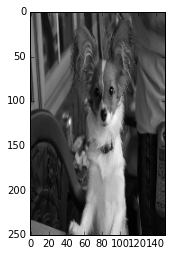

In [101]:
lab, img = sess.run(get_values(rec=_imgs[0]))
plt.imshow(img, cmap='gray')

In [58]:
#features['label']
image = tf.reshape(tf.decode_raw(features['image'], tf.uint8), [250,151,1]) # the data was reshaped in write function ... must put the same shape
label = tf.cast(features['label'], tf.string)


<tf.Tensor 'ParseSingleExample_141/Squeeze_label:0' shape=() dtype=string>

In [36]:
features = tf.parse_single_example(
        value,
        features={
            'label':tf.FixedLenFeature([], tf.string),
            'image':tf.FixedLenFeature([], tf.string)
        })

    # definition of shape and data types
    image = tf.reshape(tf.decode_raw(features['image'], tf.uint8), [250,151,1]) # the data was reshaped in write function ... must put the same shape
    label = tf.cast(features['label'], tf.string)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [22]:
read_file = tf.python_io.tf_record_iterator(error_log[0])
reader = tf.TFRecordReader()
_, value = reader.read(i)

features = tf.parse_single_example(
    value,
    features={
        'label':tf.FixedLenFeature([], tf.string),
        'image':tf.FixedLenFeature([], tf.string)
    })

# definition of shape and data types
image = tf.reshape(tf.decode_raw(features['image'], tf.uint8), [250,151,1]) # the data was reshaped in write function ... must put the same shape
label = tf.cast(features['label'], tf.string)

sess = tf.Session()

for i in tf.python_io.tf_record_iterator(error_log[0]):
    sess.run(i)

AttributeError: 'str' object has no attribute 'queue_ref'

In [18]:
check_tfrecords_file(error_log[0])

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.DataLossError'>, truncated record at 2951130
	 [[Node: ReaderRead_43 = ReaderRead[_class=["loc:@TFRecordReader_43", "loc:@input_producer_43"], _device="/job:localhost/replica:0/task:0/cpu:0"](TFRecordReader_43, input_producer_43)]]

Caused by op u'ReaderRead_43', defined at:
  File "/home/mbledowski/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mbledowski/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in star

OutOfRangeError: RandomShuffleQueue '_29120_shuffle_batch_138/random_shuffle_queue' is closed and has insufficient elements (requested 10, current size 9)
	 [[Node: shuffle_batch_138 = QueueDequeueMany[_class=["loc:@shuffle_batch_138/random_shuffle_queue"], component_types=[DT_UINT8, DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch_138/random_shuffle_queue, shuffle_batch_138/n)]]

Caused by op u'shuffle_batch_138', defined at:
  File "/home/mbledowski/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mbledowski/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2831, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-1ce53c0e190a>", line 1, in <module>
    check_tfrecords_file(error_log[0])
  File "<ipython-input-16-aeb91196cda1>", line 31, in check_tfrecords_file
    min_after_dequeue=min_after_dequeue)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/input.py", line 917, in shuffle_batch
    dequeued = queue.dequeue_many(batch_size, name=name)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/data_flow_ops.py", line 458, in dequeue_many
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 1099, in _queue_dequeue_many
    timeout_ms=timeout_ms, name=name)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/mbledowski/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

OutOfRangeError (see above for traceback): RandomShuffleQueue '_29120_shuffle_batch_138/random_shuffle_queue' is closed and has insufficient elements (requested 10, current size 9)
	 [[Node: shuffle_batch_138 = QueueDequeueMany[_class=["loc:@shuffle_batch_138/random_shuffle_queue"], component_types=[DT_UINT8, DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch_138/random_shuffle_queue, shuffle_batch_138/n)]]
